In [1]:
import pandas as pd

# Load the datasets
applications_df = pd.read_csv('cleaned_applications.csv')
branches_df = pd.read_csv('cleaned_branches.csv')
customers_df = pd.read_csv('cleaned_customers.csv')
defaults_df = pd.read_csv('cleaned_defaults.csv')
loans_df = pd.read_csv('cleaned_loans.csv')
transactions_df = pd.read_csv('cleaned_transactions.csv')

print("Datasets loaded successfully.")

Datasets loaded successfully.


In [2]:
defaults_loans_df = pd.merge(defaults_df, loans_df, on='Loan_ID', how='left')
display(defaults_loans_df.head())

Default_ID  Loan_ID Customer_ID_x Default_Date  Default_Amount  \
0    D000001  L007312       C007312   2022-07-20           94480   
1    D000002  L028234       C028234   2023-09-23           10912   
2    D000003  L008319       C008319   2024-08-04           73711   
3    D000004  L046668       C046668   2021-10-16           48955   
4    D000005  L082934       C082934   2024-10-07           56952   

      Default_Reason Recovery_Status  Recovery_Amount Legal_Action  \
0           Job Loss            Full            30360          Yes   
1           Job Loss         Partial                0          Yes   
2              Other  Not Applicable             9866          Yes   
3              Other  Not Applicable                0          Yes   
4  Medical Emergency  Not Applicable                0           No   

  Customer_ID_y  Loan_Amount  Interest_Rate  Loan_Term Disbursal_Date  \
0       C000502      3830000           9.07         12     2022-07-08   
1       C040031      1760443          12.51         60     2023-10-24   
2       C035290      2388961          10.78         36     2022-01-25   
3       C001996      3033645          11.44         12     2023-09-18   
4       C039067      4667765          10.30         48     2024-08-06   

  Repayment_Start_Date Repayment_End_Date Loan_Status  Overdue_Amount  \
0           2022-08-08         2023-07-08      Active           44605   
1           2023-11-24         2028-10-24      Closed               0   
2           2022-02-25         2025-01-25     Overdue               0   
3           2023-10-18         2024-09-18      Active               0   
4           2024-09-06         2028-08-06      Active           47466   

   EMI_Amount Collateral_Details  
0       20902           Property  
1       96725           Property  
2       78109     Not Applicable  
3       13609     Not Applicable  
4       41827     Not Applicable

In [3]:
# Define bins and labels for categorization
default_amount_bins = defaults_loans_df['Default_Amount'].quantile([0, 0.33, 0.66, 1]).tolist()
loan_term_bins = defaults_loans_df['Loan_Term'].quantile([0, 0.33, 0.66, 1]).tolist()
interest_rate_bins = defaults_loans_df['Interest_Rate'].quantile([0, 0.33, 0.66, 1]).tolist()
risk_labels = ['Low', 'Medium', 'High']

# Create new categorical columns
defaults_loans_df['Default_Amount_Category'] = pd.cut(defaults_loans_df['Default_Amount'], bins=default_amount_bins, labels=risk_labels, include_lowest=True)
defaults_loans_df['Loan_Term_Category'] = pd.cut(defaults_loans_df['Loan_Term'], bins=loan_term_bins, labels=risk_labels, include_lowest=True)
defaults_loans_df['Interest_Rate_Category'] = pd.cut(defaults_loans_df['Interest_Rate'], bins=interest_rate_bins, labels=risk_labels, include_lowest=True)

# Assign numerical scores
risk_score_map = {'Low': 1, 'Medium': 2, 'High': 3}
defaults_loans_df['Risk_Score'] = defaults_loans_df['Default_Amount_Category'].map(risk_score_map).astype(int) + \
                                defaults_loans_df['Loan_Term_Category'].map(risk_score_map).astype(int) + \
                                defaults_loans_df['Interest_Rate_Category'].map(risk_score_map).astype(int)

# Define risk levels based on Risk_Score
risk_level_bins = defaults_loans_df['Risk_Score'].quantile([0, 0.33, 0.66, 1]).tolist()
defaults_loans_df['Risk_Level'] = pd.cut(defaults_loans_df['Risk_Score'], bins=risk_level_bins, labels=risk_labels, include_lowest=True)

display(defaults_loans_df[['Default_Amount', 'Default_Amount_Category', 'Loan_Term', 'Loan_Term_Category', 'Interest_Rate', 'Interest_Rate_Category', 'Risk_Score', 'Risk_Level']].head())

Default_Amount Default_Amount_Category  Loan_Term Loan_Term_Category  \
0           94480                    High         12                Low   
1           10912                     Low         60               High   
2           73711                    High         36             Medium   
3           48955                  Medium         12                Low   
4           56952                  Medium         48             Medium   

   Interest_Rate Interest_Rate_Category  Risk_Score Risk_Level  
0           9.07                    Low           5        Low  
1          12.51                   High           7       High  
2          10.78                 Medium           7       High  
3          11.44                 Medium           5        Low  
4          10.30                 Medium           6     Medium

In [4]:
display(defaults_loans_df['Risk_Level'].value_counts())

Risk_Level
Low       3714
High      2907
Medium    2379
Name: count, dtype: int64

In [5]:
defaults_loans_applications_df = pd.merge(defaults_loans_df, applications_df[['Loan_ID', 'Loan_Purpose']], on='Loan_ID', how='left')

loan_type_risk = defaults_loans_applications_df.groupby('Loan_Purpose')['Risk_Score'].mean().reset_index()
loan_type_risk = loan_type_risk.sort_values(by='Risk_Score', ascending=False)
loan_type_risk.rename(columns={'Risk_Score': 'Average_Risk_Score'}, inplace=True)
display(loan_type_risk)

Loan_Purpose  Average_Risk_Score
1        Education            5.879742
0         Business            5.873538
4          Vehicle            5.859958
2  Home Renovation            5.784703
3         Personal            5.742232

In [6]:
high_risk_loans_df = defaults_loans_applications_df[defaults_loans_applications_df['Risk_Level'] == 'High'].copy()


In [7]:
high_risk_customers_df = pd.merge(high_risk_loans_df, customers_df[['Customer_ID', 'Credit_Score', 'Annual_Income']], left_on='Customer_ID_x', right_on='Customer_ID', how='left')

# Analyze descriptive statistics
print("Descriptive statistics for Credit_Score in high-risk customers:")
display(high_risk_customers_df['Credit_Score'].describe())

print("\nDescriptive statistics for Annual_Income in high-risk customers:")
display(high_risk_customers_df['Annual_Income'].describe())

Descriptive statistics for Credit_Score in high-risk customers:


count    2267.000000
mean      573.307014
std       160.734038
min       300.000000
25%       434.000000
50%       575.000000
75%       712.000000
max       850.000000
Name: Credit_Score, dtype: float64


Descriptive statistics for Annual_Income in high-risk customers:


count    2.267000e+03
mean     1.101436e+06
std      5.231103e+05
min      2.008300e+05
25%      6.479295e+05
50%      1.098135e+06
75%      1.568732e+06
max      1.998603e+06
Name: Annual_Income, dtype: float64

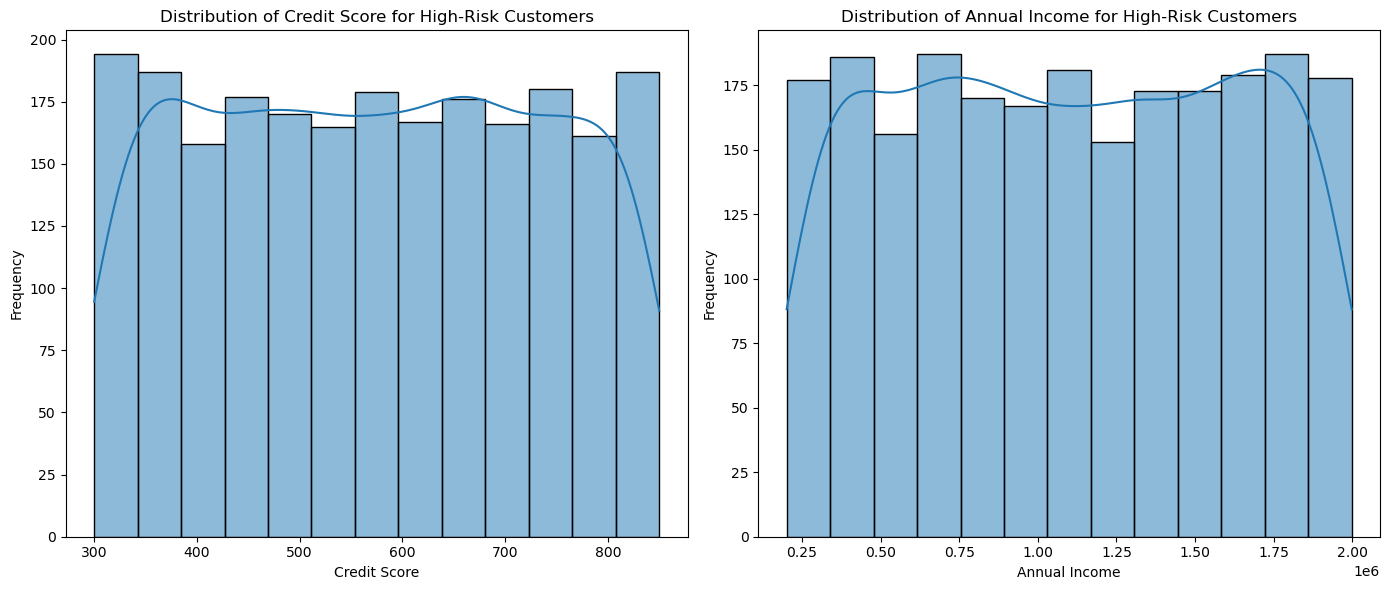

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(high_risk_customers_df['Credit_Score'].dropna(), kde=True, ax=axes[0])
axes[0].set_title('Distribution of Credit Score for High-Risk Customers')
axes[0].set_xlabel('Credit Score')
axes[0].set_ylabel('Frequency')

sns.histplot(high_risk_customers_df['Annual_Income'].dropna(), kde=True, ax=axes[1])
axes[1].set_title('Distribution of Annual Income for High-Risk Customers')
axes[1].set_xlabel('Annual Income')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [9]:
print("Summary of Key Risk Assessment Findings:")

print("\nRisk Matrix Development:")
print("A risk matrix was developed using Default Amount, Loan Term, and Interest Rate. Each of these factors was categorized into 'Low', 'Medium', and 'High' based on quantiles. A composite 'Risk Score' was calculated by summing the numerical scores (1 for Low, 2 for Medium, 3 for High) from these three categories. An overall 'Risk Level' (Low, Medium, High) was then assigned based on the quantiles of the composite 'Risk Score'.")

print("\nRanked Loan Types by Risk Level:")
print("The analysis of loan types by their average risk score revealed the following ranking (from highest to lowest average risk score):")
display(loan_type_risk)
print("Loan purposes such as Education and Business tend to have higher average risk scores compared to others.")

print("\nHigh-Risk Customer Segments:")
print("Analysis of the high-risk customer segment based on Credit Score and Annual Income showed a wide distribution for both factors.")
print("Descriptive statistics for Credit Score in high-risk customers:")
display(high_risk_customers_df['Credit_Score'].describe())
print("\nDescriptive statistics for Annual Income in high-risk customers:")
display(high_risk_customers_df['Annual_Income'].describe())
print("The distributions of Credit Score and Annual Income for high-risk customers indicate that while lower credit scores are present, a significant portion of high-risk customers also have moderate to high credit scores. Similarly, high-risk customers exhibit a broad range of annual incomes, suggesting that high income alone does not guarantee low risk. This highlights that risk is a multifaceted issue influenced by factors beyond just credit score and income.")

Summary of Key Risk Assessment Findings:

Risk Matrix Development:
A risk matrix was developed using Default Amount, Loan Term, and Interest Rate. Each of these factors was categorized into 'Low', 'Medium', and 'High' based on quantiles. A composite 'Risk Score' was calculated by summing the numerical scores (1 for Low, 2 for Medium, 3 for High) from these three categories. An overall 'Risk Level' (Low, Medium, High) was then assigned based on the quantiles of the composite 'Risk Score'.

Ranked Loan Types by Risk Level:
The analysis of loan types by their average risk score revealed the following ranking (from highest to lowest average risk score):


Loan_Purpose  Average_Risk_Score
1        Education            5.879742
0         Business            5.873538
4          Vehicle            5.859958
2  Home Renovation            5.784703
3         Personal            5.742232

Loan purposes such as Education and Business tend to have higher average risk scores compared to others.

High-Risk Customer Segments:
Analysis of the high-risk customer segment based on Credit Score and Annual Income showed a wide distribution for both factors.
Descriptive statistics for Credit Score in high-risk customers:


count    2267.000000
mean      573.307014
std       160.734038
min       300.000000
25%       434.000000
50%       575.000000
75%       712.000000
max       850.000000
Name: Credit_Score, dtype: float64


Descriptive statistics for Annual Income in high-risk customers:


count    2.267000e+03
mean     1.101436e+06
std      5.231103e+05
min      2.008300e+05
25%      6.479295e+05
50%      1.098135e+06
75%      1.568732e+06
max      1.998603e+06
Name: Annual_Income, dtype: float64

The distributions of Credit Score and Annual Income for high-risk customers indicate that while lower credit scores are present, a significant portion of high-risk customers also have moderate to high credit scores. Similarly, high-risk customers exhibit a broad range of annual incomes, suggesting that high income alone does not guarantee low risk. This highlights that risk is a multifaceted issue influenced by factors beyond just credit score and income.
